## Ejemplo de Pendulum

In [1]:
# env = gym.make("Pendulum-v1", render_mode="human")
# observation, info = env.reset()

# for _ in range(250):
#     action = env.action_space.sample()  # agent policy that uses the observation and info
#     observation, reward, terminated, truncated, info = env.step(action)

#     print(observation, reward, terminated, truncated, info)

#     if terminated or truncated:
#         observation, info = env.reset()

# env.close()

## Basic

In [2]:
import gymnasium as gym
import math
import random
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np

In [3]:
#env = gym.make("Pendulum-v1")
env = gym.make("Pendulum-v1", render_mode="human", g=9.81)


# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

# if GPU is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(torch.cuda.is_available())

# ********************************************************************

def calculate_reward(observ, torque, target_angle):
    #theta, theta_dot = state
    theta = math.acos(observ[0])
    theta_dot = observ[2]

    theta_n = ((theta + np.pi) % (2*np.pi)) - np.pi

    theta_error = np.abs(theta_n - target_angle)
    
    costs = theta_error**2 + 0.1 * theta_dot**2 + 0.001 * (torque**2)

    if theta_error <= 0.17: # ~ 10°
        reward_n = -costs + 0.5
    else:
        reward_n = -costs

    return torch.tensor([reward_n], device=device)

True


## Replay Memory

In [4]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))


class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

## DQN Algorithm

### Q-network

In [5]:
class DQN(nn.Module):

    def __init__(self, n_observations, n_actions):
        super(DQN, self).__init__()
        self.layer1 = nn.Linear(n_observations, 128)
        self.layer2 = nn.Linear(128, 128)
        self.output_layer = nn.Linear(128, n_actions)

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.output_layer(x)
    
# class DQN(nn.Module):
#     def __init__(self, n_observations, n_actions):
#         super(DQN, self).__init__()
#         self.layer1 = nn.Linear(n_observations, 16)
#         self.layer2 = nn.Linear(16, 32)
#         self.layer3 = nn.Linear(32, 64)
#         self.layer4 = nn.Linear(64, 64)
#         self.output_layer = nn.Linear(64, n_actions)

#     def forward(self, x):
#         x = F.relu(self.layer1(x))
#         x = F.relu(self.layer2(x))
#         x = F.relu(self.layer3(x))
#         x = F.relu(self.layer4(x))
#         return self.output_layer(x)




## Training

In [6]:
BATCH_SIZE = 128    # number of transitions sampled from the replay buffer
GAMMA = 0.99        # discount factor as mentioned in the previous section
EPS_START = 0.9     # starting value of epsilon
EPS_END = 0.05      # final value of epsilon
EPS_DECAY = 1000    # controls the rate of exponential decay of epsilon, higher means a slower decay
TAU = 0.005         # update rate of the target network
LR = 1e-4           # learning rate of the ``AdamW`` optimizer

# **************************************
# **************************************

n_actions = 1       # Discretizacion

# uMax = 2
# DU = 2*uMax/(n_actions-1)

# # **************************************
# # **************************************
 
# # torch.clamp() es la función equivalente a np.clip() y torch.floor() es la función equivalente a np.floor()

# def c2du(u):
#     u = torch.clamp(u,-uMax,uMax)
#     return torch.floor((u+uMax)/DU)

# def d2cu(iu):
#     iu = torch.clamp(iu,0,n_actions-1) - (n_actions-1)/2
#     return iu*DU

# **************************************
# **************************************

state, info = env.reset()
n_observations = len(state)

policy_net = DQN(n_observations, n_actions).to(device)
target_net = DQN(n_observations, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())

optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)
memory = ReplayMemory(10000)


steps_done = 0

# **************************************
# **************************************

def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            # t.max(1) will return the largest column value of each row.
            # second column on max result is index of where max element was
            # found, so we pick action with the larger expected reward.
            #return policy_net(state).max(1).indices.view(1, 1)
            newvalue = policy_net(state).max(1).indices.view(1, 1).item()
            if newvalue == 0:
                return [0]
            else:
                return newvalue 
    else:
        #return torch.tensor([[env.action_space.sample()]], device=device, dtype=torch.float32)
        newvalue = env.action_space.sample()
        if newvalue == 0:
            return [0]
        else:
            return newvalue 
        

# def select_action(state):
#     global steps_done
#     sample = random.random()
#     eps_threshold = EPS_END + (EPS_START - EPS_END) * \
#         math.exp(-1. * steps_done / EPS_DECAY)
#     steps_done += 1
#     if sample > eps_threshold:
#         with torch.no_grad():
#             # 
#             return c2du(torch.argmax(policy_net(state)))
#     else:
#         return c2du(torch.argmax(policy_net(state)))
#     torch.tensor([[env.action_space.sample()]], device=device, dtype=torch.float32)


# **************************************
# **************************************

episode_rewards = []


def plot_rewards(show_result=False):
    plt.figure(1)
    rewards_t = torch.tensor(episode_rewards, dtype=torch.float)
    if show_result:
        plt.title('Result')
    else:
        plt.clf()
        plt.title('Training...')
    plt.xlabel('Time steps (gray lines=episode)')
    plt.ylabel('Reward')
    plt.plot(rewards_t.numpy(), linewidth=0.5)
    # Take 100 episode averages and plot them too
    if len(rewards_t) >= 100:
        means = rewards_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())

    # Añadir líneas verticales rojas en cada t=200
    for t in range(200, len(rewards_t) + 1, 200):
        plt.axvline(x=t, color='gray')

    plt.pause(0.001)  # pause a bit so that plots are updated
    if is_ipython:
        if not show_result:
            display.display(plt.gcf())
            display.clear_output(wait=True)
        else:
            display.display(plt.gcf())

### Training Loop

In [7]:
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
    # detailed explanation). This converts batch-array of Transitions
    # to Transition of batch-arrays.
    batch = Transition(*zip(*transitions))

    # Compute a mask of non-final states and concatenate the batch elements
    # (a final state would've been the one after which simulation ended)
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    state_batch = torch.cat(batch.state)
    #action_batch = torch.cat(batch.action)
    action_batch = torch.tensor(np.concatenate(batch.action))
    reward_batch = torch.cat(batch.reward)

    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken. These are the actions which would've been taken
    # for each batch state according to policy_net
    
    #state_action_values = policy_net(state_batch).gather(1, action_batch)
    state_action_values = policy_net(state_batch)

    # Compute V(s_{t+1}) for all next states.
    # Expected values of actions for non_final_next_states are computed based
    # on the "older" target_net; selecting their best reward with max(1).values
    # This is merged based on the mask, such that we'll have either the expected
    # state value or 0 in case the state was final.
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    with torch.no_grad():
        next_state_values[non_final_mask] = target_net(non_final_next_states).max(1).values
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Compute Huber loss
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    # In-place gradient clipping
    torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
    optimizer.step()

Complete


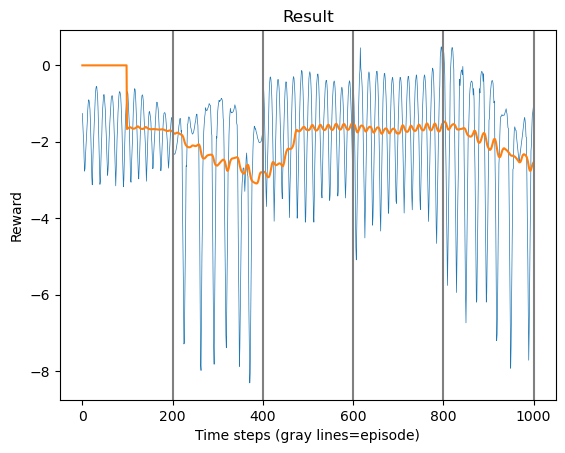

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [8]:
if torch.cuda.is_available():
    #num_episodes = 600
    num_episodes = 5
else:
    #num_episodes = 50
    num_episodes = 10

new_rewards = []

target_angle = 90

for i_episode in range(num_episodes):
    # Initialize the environment and get its state
    state, info = env.reset()
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    for t in count():
        #action = select_action(state)
        action = np.array(select_action(state), dtype=np.float32)
        observation, reward, terminated, truncated, _ = env.step(action)

        # ///////////////////////////////////////////////////////////
        #reward = torch.tensor([reward], device=device)
        reward = calculate_reward(observation, action.item(), math.radians(target_angle))

        # ///////////////////////////////////////////////////////////

        done = terminated or truncated


        ## ***************************
        pole_angle = math.degrees(math.acos(observation[0]))
        #reward = calculate_reward(pole_angle)

        vala = state[0].cpu().numpy()
        print(vala)
        #print(np.array([pole_angle, action.item(), reward.item()]))
        # print(pole_angle)
        # print(action.item())
        # print(reward.item())
        new_rewards.append(reward.item())
        ## ***************************



        if terminated:
            next_state = None
        else:
            next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)

        # Store the transition in memory
        memory.push(state, action, next_state, reward)

        # Move to the next state
        state = next_state

        # Perform one step of the optimization (on the policy network)
        optimize_model()
        
        ## ***************************
        # Guardar el modelo
        torch.save(policy_net.state_dict(), "models/Pendulum_"+str(num_episodes)+"eps.pth")
        # Cargar el modelo
        #model = TheModelClass(*args, **kwargs)
        #model.load_state_dict(torch.load(PATH))
        #model.eval()
        ## ***************************

        # Soft update of the target network's weights
        # θ′ ← τ θ + (1 −τ )θ′
        target_net_state_dict = target_net.state_dict()
        policy_net_state_dict = policy_net.state_dict()
        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
        target_net.load_state_dict(target_net_state_dict)

        if done:
            episode_rewards = episode_rewards + new_rewards
            new_rewards = []
            plot_rewards()
            break

print('Complete')
plot_rewards(show_result=True)
plt.ioff()
plt.show()
env.close()